# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-S109A Introduction to Data Science


## Lab 4: Principle Component Analysis (PCA), Logistcic Regression and KNN Classification

**Harvard University**<br>
**Summer 2020**<br>
**Contributors:** Will Claybaugh, David Sondak, Chris Tanner, Arpit Panda, Shivam Raval

---

In [30]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents

<ol start="0">
  <li> Learning Goals </li>
  <li> Principal Components Analysis </li>
  <li> Logistic Regression </li>
  <li> K-NN Classification </li>
  <li> Model Evaluation Metrics</li>
</ol>

##### Learning Goals
In this lab, we will look at how to use PCA to reduce a dataset to a smaller number of dimensions. The goal is for students to:
<ul>
  <li>Understand what PCA is and why it's useful</li>
  <li>Feel comfortable performing PCA on a new dataset</li>
  <li>Be able to extract the `variance explained` by components.</li>
  <li>Perform modeling with the PCA components</li>
</ul> 

Furthermore, we will look at the two forms of Classification:

<ul>
  <li>Logistic Regression</li>
  <li>KNN Classsification</li>
</ul>

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Linear Regression
 - Logistic Regression
- Be able to evaluate the models based on different metrics (Confusion matrix and ROC curves)


In [31]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score

pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams["figure.figsize"] = (12,8)

from sklearn.model_selection import train_test_split

## Part 1a:  PCA Review

What is PCA? PCA is a deterministic technique to transform data to a lowered dimensionality, whereby each feature/dimension captures the most variance possible.

Why do we care to use it?
<ul>
  <li>Visualizating the components can be useful</li>
  <li>Allows for more efficient use of resources (time, memory)</li>
  <li>Statistical reasons: fewer dimensions -> better generalization</li>
  <li>noise removal / collinearity (improving data quality)</li>
</ul>  

Imagine some dataset where we have two features that are pretty redundant. For example, maybe we have data concerning elite runners. Two of the features may include ``VO2 max`` and ``heartrate``. These are highly correlated. We probably don't need both, as they don't offer much additional information from each other. Using a [great visual example from online](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues), let's say that this unlabelled graph **(always label your axis)** represents those two features:

![VO2 Max vs Heart Rate](original_data.png)

Let's say that this is our entire dataset, just 2 dimensions. If we wish to reduce the dimensions, we can only reduce it to just 1 dimension. A straight line is just 1 dimension (to help clarify this: imagine your straight line as being the x-axis, and values can be somewhere on this axis, but that's it. There is no y-axis dimension for a straight line). So, how should PCA select a straight line through this data?

Below, the image shows all possible projects that are centered in the data:

![Animation of possible lines](animation.gif)

PCA picks the line that:
<ul>
<li>captures the most variance possible</li>
<li>minimizes the distance of the transformed points (distance from the original to the new space)</li>
</ul>

The animation **suggests** that these two aspects are actually the same. In fact, this is objectively true, but the proof for which is beyond the scope of the material for now. Feel free to read more at [this explanation](https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m/136072#136072) and via [Andrew Ng's notes](http://cs229.stanford.edu/notes/cs229-notes-all/cs229-notes10.pdf).

In short, PCA is a math technique that works with the covariance matrix -- the matrix that describes how all pairwise features are correlated with one another. Covariance of two variables measures the degree to which they moved/vary in the same direction; how much one variable affects the other. A positive covariance means they are positively related (i.e., x1 increases as x2 does); negative means negative correlation (x1 decreases as x2 increases).

In data science and machine learning, our models are often just finding patterns in the data this is easier if the data is spread out across each dimension and for the data features to be independent from one another (imagine if there's no variance at all. We couldn't do anything). Can we transform the data into a new set that is a linear combination of those original features?

PCA finds new dimensions (set of basis vectors) such that all the dimensions are orthogonal and hence linearly independent, and ranked according to the variance (eigenvalue). That is, the first component is the most important, as it captures the most variance.

## Part 1b:  Intro to the Wine Dataset

Imagine that a wine sommelier has tasted and rated 1,000 distinct wines, and now that she's highly experienced, she is curious if she can more efficiently rate wines without even trying them. That is, perhaps her tasting preferences follow a pattern, allowing her to predict the rating a new wine without even trying it!  

The dataset contains 11 chemical features, along with a quality scale from 1-10; however, only values of 3-9 are actually used in the data. The ever-elusive perfect wine has yet to be tasted. 

#### **NOTE:** While this dataset involves the topic of alcohol, we, the s-CS109A staff, along with Harvard at large is in no way encouraging alcohol use, and this example should not be intrepreted as any endorsement for such; it is merely a pedagogical example. I apologize if this example offends anyone or is off-putting.



### Read-in and checking
First, let's read-in the data and verify it:

In [32]:
wines_df = pd.read_csv("./data/wines.csv", index_col=0)
wines_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
0,8.9,0.590,0.50,2.0,0.337,27.0,81.0,0.99640,3.04,1.61,9.5,6,1
1,7.7,0.690,0.22,1.9,0.084,18.0,94.0,0.99610,3.31,0.48,9.5,5,1
2,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,5,1
3,11.4,0.460,0.50,2.7,0.122,4.0,17.0,1.00060,3.13,0.70,10.2,5,1
4,8.8,0.240,0.54,2.5,0.083,25.0,57.0,0.99830,3.39,0.54,9.2,5,1


In [33]:
wines_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,7.558400,0.397455,0.30676,4.489250,0.067218,25.29650,91.03100,0.995351,3.251980,0.572990,10.489433,5.796000,0.50000
std,1.559455,0.189923,0.16783,4.112419,0.046931,17.06237,59.57269,0.002850,0.164416,0.169583,1.151195,0.844451,0.50025
min,3.800000,0.080000,0.00000,0.800000,0.009000,1.00000,6.00000,0.987400,2.740000,0.280000,8.500000,3.000000,0.00000
25%,6.500000,0.260000,0.22000,1.800000,0.042000,12.00000,37.75000,0.993480,3.140000,0.460000,9.500000,5.000000,0.00000
50%,7.200000,0.340000,0.30000,2.400000,0.060000,22.00000,86.00000,0.995690,3.240000,0.550000,10.300000,6.000000,0.50000
75%,8.200000,0.520000,0.40000,6.100000,0.080000,35.00000,135.00000,0.997400,3.360000,0.650000,11.300000,6.000000,1.00000
max,15.500000,1.580000,1.00000,26.050000,0.611000,131.00000,313.00000,1.003690,3.900000,2.000000,14.000000,8.000000,1.00000


For this exercise, let's say that the wine expert is curious if she can predict, as a rough approximation, the **categorical quality -- bad, average, or great.** Let's define those categories as follows:

- `bad` is when for wines that have a quality <= 5
- `average` is when a wine has a quality of 6 or 7
- `great` is when a wine has a quality of >= 8

In [34]:
# copy the original data so that we're free to make changes
wines_df_recode = wines_df.copy()

# use the 'cut' function to reduce a variable down to the aforementioned bins (inclusive boundaries)
wines_df_recode['quality'] = pd.cut(wines_df_recode['quality'],[0,5,7,10], labels=[0,1,2])
wines_df_recode.loc[wines_df_recode['quality'] == 1]

# drop the un-needed columns
x_data = wines_df_recode.drop(['quality'], axis=1)
y_data = wines_df_recode['quality']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.2, random_state=8, stratify=y_data)

# previews our data to check if we correctly constructed the labels (we did)
print(wines_df['quality'].head())
print(wines_df_recode['quality'].head())

0    6
1    5
2    5
3    5
4    5
Name: quality, dtype: int64
0    1
1    0
2    0
3    0
4    0
Name: quality, dtype: category
Categories (3, int64): [0 < 1 < 2]


For sanity, let's see how many wines are in each category:

In [35]:
y_data.value_counts()


1    598
0    379
2     23
Name: quality, dtype: int64

Now that we've split the data, let's look to see if there are any obvious patterns (correlations between different variables).

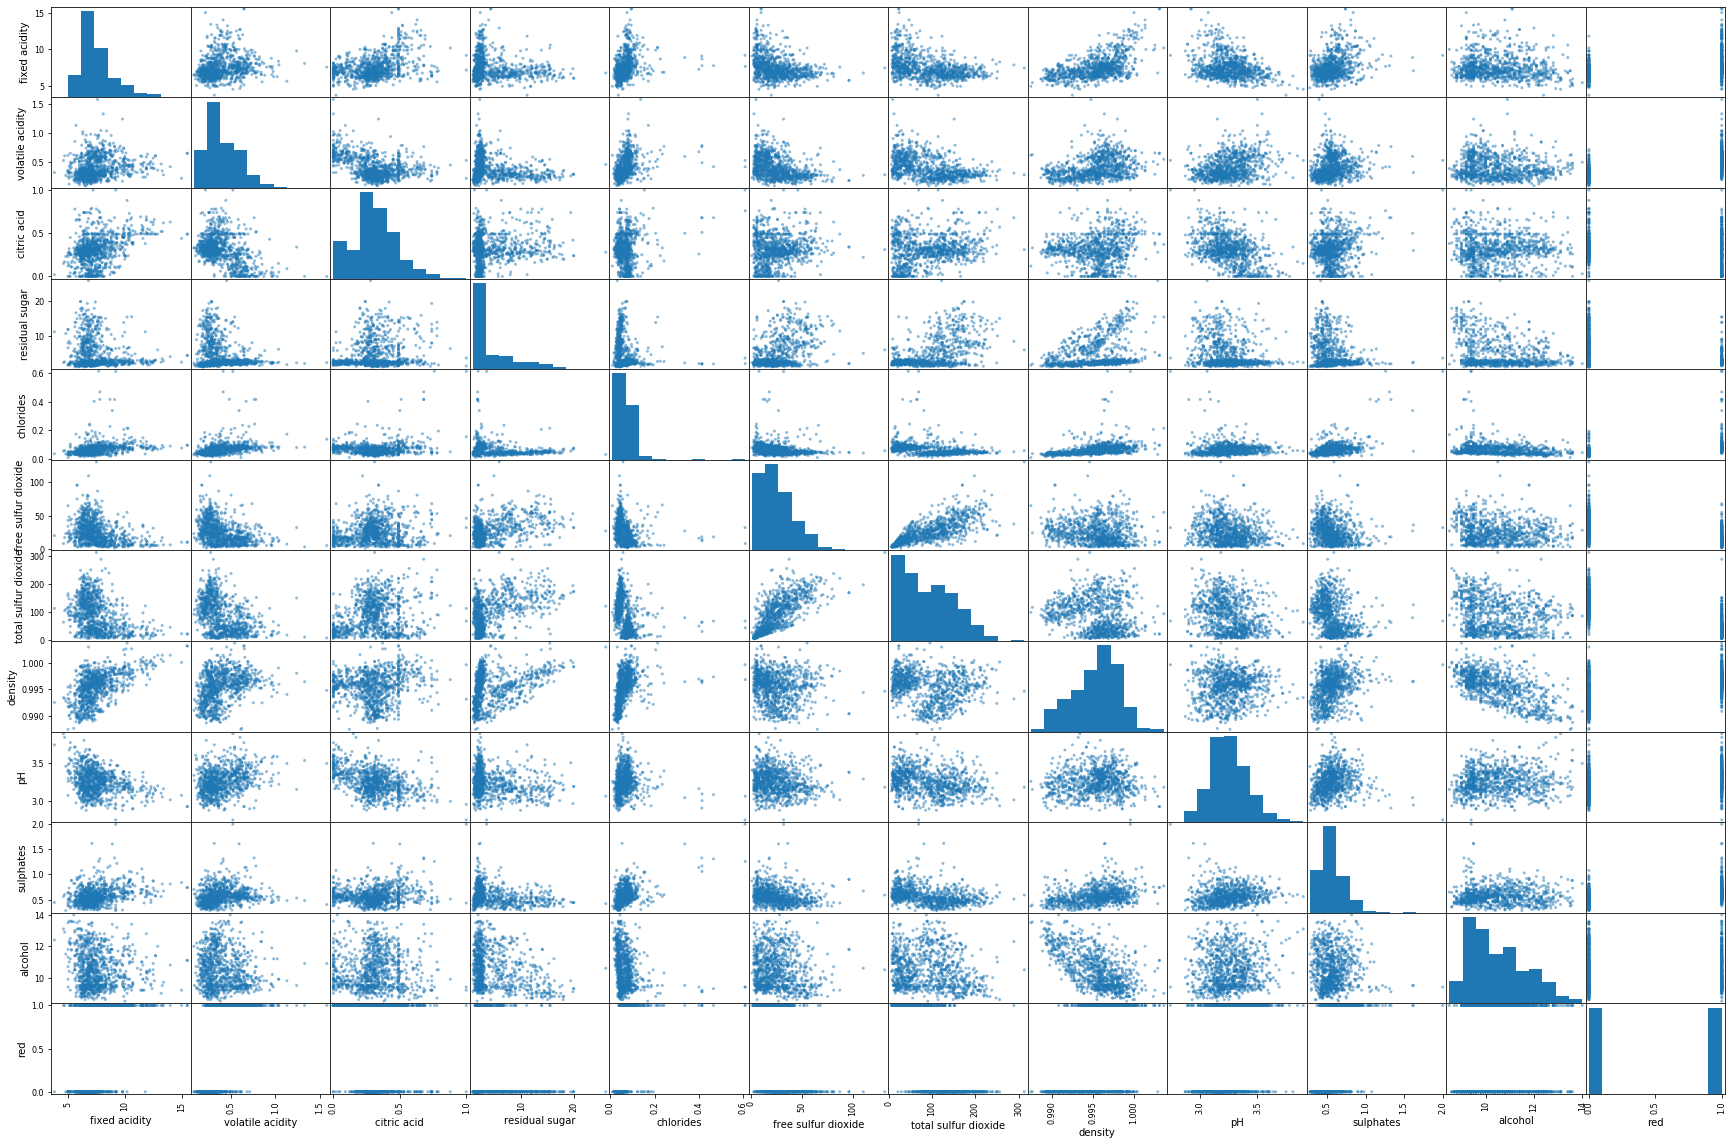

In [36]:
from pandas.plotting import scatter_matrix
scatter_matrix(wines_df_recode, figsize=(30,20));

## Part 1c: Dimensionality Reduction
In attempt to improve performance when we model our data, we may wonder if some of our features are redundant and are posing difficulties for our logistic regression model. Let's PCA to shrink the problem down to 2 dimensions (with as little loss as possible) and see if that gives us a clue about what makes this problem tough.

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_components = 2


# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_test_scaled = scale_transformer.transform(x_test)

# reduce dimensions
pca_transformer = PCA(num_components).fit(x_train_scaled)
x_train_2d = pca_transformer.transform(x_train_scaled)
x_test_2d =  pca_transformer.transform(x_test_scaled)

print(x_train_2d.shape)
x_train_2d[0:5,:]


(800, 2)


array([[-1.23949587, -2.34876616],
       [-1.13615842,  0.37632328],
       [ 1.84037474, -0.10597198],
       [ 2.00455608, -0.14333293],
       [ 1.68553308,  4.82627254]])

**NOTE:**
1. Both scaling and reducing dimension follow the same pattern: we fit the object to the training data, then use .transform() to convert the training and test data. This ensures that, for instance, we scale the test data using the _training_ mean and variance, not its own mean and variance
2. We need to equalize the variance of each feature before applying PCA; otherwise, certain dimensions will dominate the scaling. Our PCA dimensions would just be the features with the largest spread.

<div class="exercise"><b>Exercise 1.1:</b> Why didn't we scale the y-values (class labels) or transform them with PCA? Is this a mistake?</div>


*Your Answer*
The goal of PCA here is to reduce the dimensions of the predictor space. It wouldn't make much sense to include response variable/class label as well. If response variable was 'absorbed' into one of the PC's, we lose the ability to actually do inference or prediction on our response variable.


<div class="exercise"><b>Exercise 1.2:</b> Our data only has 2 dimensions/features now. What do these features represent?</div>

*Your Answer*
These features represent PC1 and PC2 which are both "eigenvectors of the covariance matrix of all predictors" in technical speak. More simply, they simply represent independent, linear combinations of all our predictors such that PC1 captures maximal variance in our data, and then PC2 captures the second most variance in our data. 

Since our data only has 2 dimensions now, we can easily visualize the entire dataset. If we choose to color each datum with respect to its associated label/class, it allows us to see how separable the data is. That is, it gives an indication as to how easy/difficult it is for a model to fit the new, transformed data.

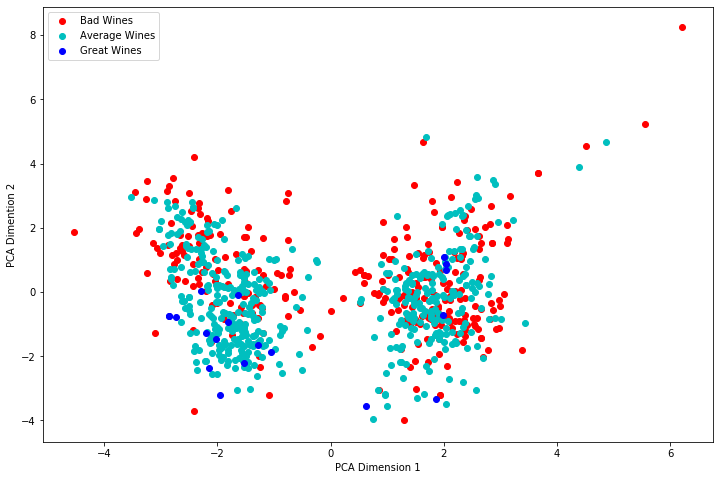

In [38]:
# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Bad Wines", "Average Wines", "Great Wines"]

# and we loop over the different groups
for cur_quality in [0,1,2]:
    cur_df = x_train_2d[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=label_text[cur_quality])

# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

Well, that gives us some idea of why the problem is difficult! The bad, average, and great wines are all on top of one another. Not only are there few great wines, which we knew from the beginning, but there is no line that can easily separate the classes of wines.

<div class="exercise"><b>Exercise 1.3:</b></div>

<ol>
  <li>What critique can you make against the plot above? Why does this plot not prove that the different wines are hopelessly similar?</li>
  <li>The wine data we've used so far consist entirely of continuous predictors. Would PCA work with categorical data?</li>
</ol>

*Your answer*
The PCA dimensions are chosen without regard to the y variable. Thus it is possible that the very next PCA dimension will lift the red points up out of the page, push the blue points down into it, and leave the cyan points where they are; such a dimension would separate the different types of wine and make classification easy.
Furthermore, PCA wouldn't really work on categorical data. PCA requires there to be a meaningful notion of distance between points. Categorical or ordinal data is not enough.


Looking at our PCA plot above, we see something peculiar: we have two disjoint clusters, both of which have immense overlap in the qualities of wines.

<div class="exercise"><b>Exercise1.4:</b> What could cause this? What does this mean?</div>

*Your answer*

Essentially, it appears that in 2-PC space, it's hard to separate out our data. No clear decision boundaries visible by the eye test. The two distinct clusters appears to indicate that there is some substructure in the data based on some other attribute of these wines. Let's explore in the next exercise.

<div class="exercise"><b>Exercise1.5:</b> Let's plot the same PCA'd data, but let's color code them according to if the wine is red or white. Does this graph help you answer our previous question? Does it change your thoughts?</div>


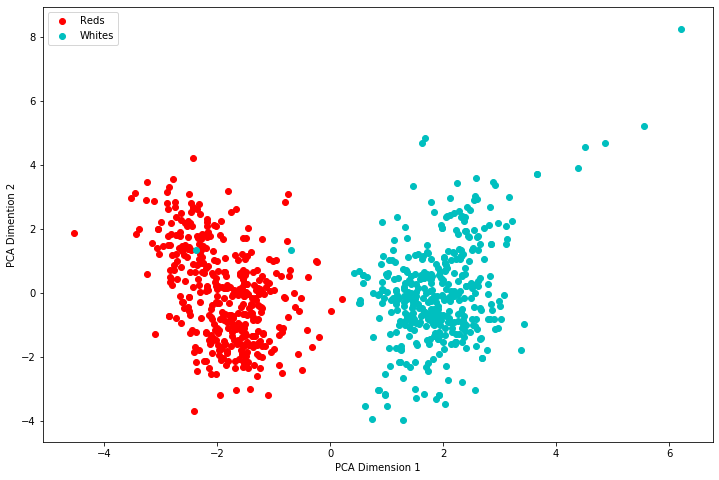

In [39]:
## plot each group

# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Reds", "Whites"]

# and we loop over the different groups
for cur_color in [0,1]:
    cur_df = x_train_2d[x_train['red']==cur_color]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_color], label=label_text[cur_color])
    
# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

*your answer*
All this means is that the majority of variance in data is explained by the redness or whiteness of the wines. This appears to be the population substructure we capturing. So, making this the classification task would be much easier.

## Part 1d. Evaluating PCA: Variance Explained And Predictions
One of the criticisms we made of the PCA plot was that it's lost something from the original data. Heck, we're only using 2 dimensions, we it's perfectly reasonable and expected for us to lose some information -- our goal was that the information we were discarding was noise.

Let's investigate how much of the original data's structure the 2-D PCA captures. We'll look at the `explained_variance_ratio_` portion of the PCA fit. This lists, in order, the percentage of the x data's total variance that is captured by the nth PCA dimension.

In [40]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each PCA component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

Variance explained by each PCA component: [0.34021651 0.20128374]
Total Variance Explained: 0.5415002511091702


The first PCA dimension captures 33% of the variance in the data, and the second PCA dimension adds another 20%. Together, we've captured about half of the total variation in the training data with just these two dimensions. So far, we've used PCA to transform our data, we've visualized our newly transformed data, and we've looked at the variance that it captures from the original dataset. That's a good amount of inspection; now let's actually use our transformed data to make predictions.



We're only using 2 dimensions. What if we increase our data to 10 PCA components?

<div class="exercise"><b>Exercise 1.6:</b></div>
<ol>
  <li>Fit a PCA that finds the first 10 PCA components of our training data</li>
  <li>Use `np.cumsum()` to print out the variance we'd be able to explain by using n PCA dimensions for n=1 through 10</li>
  <li>Does the 10-dimension PCA agree with the 2d PCA on how much variance the first components explain? **Do the 10d and 2d PCAs find the same first two dimensions? Why or why not?**</li>
    <li>Make a plot of number of PCA dimensions against total variance explained. What PCA dimension looks good to you?</li>
</ol> 

Hint: `np.cumsum` stands for 'cumulative sum', so `np.cumsum([1,3,2,-1,2])` is `[1,4,6,5,7]`

In [41]:
# Your answer
pca_10_transformer = PCA(10).fit(x_train_scaled)
pca_10_transformer

PCA(n_components=10)

In [42]:
np.cumsum(pca_10_transformer.explained_variance_ratio_)

array([0.34021651, 0.54150025, 0.6811323 , 0.76636799, 0.82514199,
       0.87163156, 0.91390547, 0.94945522, 0.9725896 , 0.98919639])

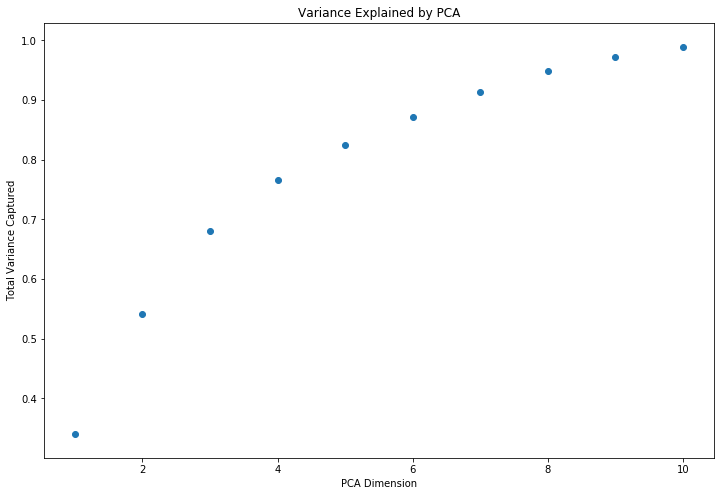

In [43]:
plt.scatter(range(1,11),np.cumsum(pca_10_transformer.explained_variance_ratio_))
plt.xlabel("PCA Dimension")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA");

The plot above can be used to inform of us when we reach diminishing returns on variance explained. That is, the 'elbow' of the line is probably an ideal number of dimensions to use, at least with respect to the amount of variance explained.

<br>

<div class="exercise"><b>Exercise 1.7:</b> Looking at your graph, what is the 'elbow' point / how many PCA components do you think we should use? Does this number of components imply that predictive performance will be optimal at this point? Why or why not?</div>

*Your answer*
Possibly around 4 or 5 is when we start hitting diminishing returns on variance explained. You can use them to heuristically select a good number of PCA dimensions.

## Part 1e: PCA Debriefing:

- PCA maps a high-dimensional space into a lower dimensional space.
- The PCA dimensions are ordered by how much of the original data's variance they capture
    - There are other cool and useful properties of the PCA dimensions (orthogonal, etc.). See a [textbook](http://math.mit.edu/~gs/linearalgebra/).
- PCA on a given dataset always gives the same dimensions in the same order.
- You can select the number of dimensions by fitting a big PCA and examining a plot of the cumulative variance explained.

PCA is not guaranteed to improve predictive performance at all. As you've learned in class now, none of our models are guaranteed to always outperform others on all datasets; analyses are a roll of the dice. The goal is to have a suite of tools to allow us to gather, process, disect, model, and visualize the data -- and to learn which tools are better suited to which conditions. Sometimes our data isn't the most conducive to certain tools, and that's okay.

What can we do about it?
1. Be honest about the methods and the null result. Lots of analyses fail.
2. Collect a dataset you think has a better chance of success. Maybe we collected the wrong chemical signals...
3. Keep trying new approaches. Just beware of overfitting the data you're validating on. Always have a test set locked away for when the final model is built.
4. Change the question. Maybe something you noticed during analysis seems interesting or useful (classifying red versus white). But again, you the more you try, the more you might overfit, so have test data locked away.
5. Just move on. If the odds of success start to seem small, maybe you need a new project.

## Part 2: Logistic Regression 

The logistic regression model is used to model the probability of a data to belong to a certain class/category. For eg:

![Cow](cow1.jpg) ![Exam_pass_curve](exam_curve.jpeg) Ref:https://en.wikipedia.org/wiki/Logistic_regression

Mathematically, this can be written as:
$$l = \log_e\left(\frac{p}{1-p}\right) = \beta_0 +\beta_1 X_1+\beta_2 X_2 $$

The equation can be used to obtain the probability for the give data to exist in a particlar class. They can be assigned particular classes bases on this probability using a cut-off condition.

### Performance of a simple classification model

Let us first look at the performance of a simplest classification model (MLE) on the data. The model under consideration is not the best one to use on such data, and we will be able to see why.

We will explore the Wines dataset which has 3 classes "Bad Wines", "Average Wines" and "Great Wines." This is a mult-class problem where we have 3 categories that have been defined as 0, 1 and 2 in our dataframes previously. 

#### Maximum-likelihood estimation (MLE)

MLE is a naive model that is doesnt require any training or any parameters (ignoring your preictors). It selects class value that makes the observed data most probable, thereby maximizing the likelihood function. Essentially, it returns the class that is seen in the data with the most freuency. So in our case, if you were to pick a wine at random, it would give you the class that it could most probably belong to. 


In [44]:
mle_y = y_data.value_counts().idxmax()
print('The MLE class is:', mle_y)

The MLE class is: 1


The class 1 corresponds to wine being classified as average. This makes sense as naively saying a wine you pick at random could be of average quality is a sensible argument. Let see how true it actually is in the next excercise

<div class="exercise"><b>Exercise 2.1:</b>  Use the train data, find the MLE and y that is the most probable, where 𝑦∈{0,1,2}. Check what is the accuracy of the model on the train and test data (the % that are correctely classified).</div>

In [45]:
# Your Answer
mle_y = y_train.value_counts().idxmax()

train_accuracy = y_train.value_counts()[mle_y] / len(y_train)

test_accuracy = y_test.value_counts()[mle_y] / len(y_test)

In [46]:
print('The train MLE class is:', mle_y)

The train MLE class is: 1


In [47]:
train_accuracy

0.5975

In [48]:
test_accuracy

0.6

So it looks like just predicting the class to be MLE without looking at the x data is not a great approach, we seem to be doing a little better than selecting a class at random. Let's see how our classsification models fare!

### Single predictor Logistic Regression

See [.predict()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) documentation here. **NOTE:** regularization is applied by default. Especially pay attention to the following arguments/parameters:

- `C` penalty, which we discussed in class. Experiment with varying values from 0 to 100 million! 
- `max_iterations`: experiment with values from 5 to 5000. Do you expect more iterations to always perform better? Why or why not?
- `penalty`: for designating 'l1' (Lasso) or 'l2' (Ridge) loss; default is 'l2' (can be set to 'none' to get unregularized estimates)
- `solver`: especially for the multi-class setting

In [49]:
from sklearn.linear_model import LogisticRegression

logref = LogisticRegression(fit_intercept=True)

In [50]:
x_train1 = x_train['red'].to_numpy().reshape(-1,1)
x_test1 = x_test['red'].to_numpy().reshape(-1,1)

In [51]:
logref.fit(x_train1, y_train)

LogisticRegression()

In [52]:
y_hat_test = logref.predict(x_test1)
initial_score = accuracy_score(y_test.to_numpy(), y_hat_test)
b0 = logref.intercept_
b1 = logref.coef_
print("Our single predictor logistic regression model yields accuracy score of:", initial_score)
print("The estimated coefficients for this simple logistic regression model are: \n", b0, "\n", b1)



Our single predictor logistic regression model yields accuracy score of: 0.6
The estimated coefficients for this simple logistic regression model are: 
 [ 0.52071517  1.26406547 -1.78478064] 
 [[ 0.5200293 ]
 [-0.03603503]
 [-0.48399427]]


In [53]:
best_accuracy = -1
best_model = None

c_vals = [0.001, 0.1, 1, 10, 100]
for c_val in c_vals:
    
    logref = LogisticRegression(C=c_val, solver='liblinear', max_iter=1000)
    logref.fit(x_train1, y_train)
    y_hat_test = logref.predict(x_test1)
    cur_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test)

    if cur_accuracy > best_accuracy:
        best_accuracy = cur_accuracy
        best_model = logref

In [54]:
print("Best found logistic regression model:", best_model,"\nAccuracy score:", best_accuracy)

Best found logistic regression model: LogisticRegression(C=0.001, max_iter=1000, solver='liblinear') 
Accuracy score: 0.6


The logistic regression model already outperforms the naive MLE model.

**NOTE:** 

- The reason we do not use linear regression here is because our goal is different here. This is a **classification** problem ( where we are concerned with predicting outputs that belong to certain categories), and not **regression** problem (predicting outputs which can be continuous-valued and can take any value).

- Another reason that Linear Regression does not work here is that the ordering of classes (0,1,2) is arbitrarily chosen by us. There is no reson to assign them as such, we could swap them around and the structure of the problem and the output remains the same. This would not work for Linear Regression.

### Multi predictor Logistic Regression

Now lets use all of our predictors and biuld our model!

<div class="exercise"><b>Exercise 2.2:</b> Use the full training data to fit the Multiple predictor Logistic Regression model. Vary the fit paramters (C value, number of iterations, solver, etc) and see if you can increase the accuracy. What do you notice? </div>

After fitting the model, you can print the ``.coef_`` value to see its $\hat{\beta}$ coefficient estimates.

In [55]:
#Your answer
best_accuracy = -1
best_model = None

# experiment with different values
c_vals = [0.0001,0.001,0.01,0.1,1, 10, 100, 1000, 10000, 100000]
num_iters = [5, 10, 100, 1000, 5000, 10000]
for c_val in c_vals:
    for num_iter in num_iters:
        logref = LogisticRegression(C=c_val, solver='liblinear', max_iter=num_iter)
        logref.fit(x_train, y_train)
        y_hat_test = logref.predict(x_test)
        cur_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test)

        if cur_accuracy > best_accuracy:
            best_accuracy = cur_accuracy
            best_model = logref
            best_iter = num_iter

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblin

In [56]:
print("Best found logistic regression model:", best_model, "\nNo of iterations needed :",best_iter,"\nAccuracy score:", best_accuracy, '\n')

Best found logistic regression model: LogisticRegression(C=1000, solver='liblinear') 
No of iterations needed : 100 
Accuracy score: 0.745 



In [57]:
print("Number of Learned coefficients:", len(best_model.coef_[0]))
print("The coefficients should match the number of features we have:", x_test.shape[1])

Number of Learned coefficients: 12
The coefficients should match the number of features we have: 12


In [58]:
for i in range(len(x_test.columns)):
    print("Feature:", x_test.columns[i], ";  Coef:", best_model.coef_[0][i])

Feature: fixed acidity ;  Coef: -0.08491825684314742
Feature: volatile acidity ;  Coef: 3.9790720586781236
Feature: citric acid ;  Coef: 0.8246543460497875
Feature: residual sugar ;  Coef: -0.07457389009184974
Feature: chlorides ;  Coef: 0.5799813942809434
Feature: free sulfur dioxide ;  Coef: -0.007393109339510175
Feature: total sulfur dioxide ;  Coef: 0.00868588752190544
Feature: density ;  Coef: 5.52066121713523
Feature: pH ;  Coef: -0.28848168829455717
Feature: sulphates ;  Coef: -1.4122380165845911
Feature: alcohol ;  Coef: -1.1128539357906109
Feature: red ;  Coef: 0.3837699585374672


**NOTE:** If the different predictors have different range of values, it is generally a good idea to standardize or normalize them...especially when using regularization.

### Regularization in Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegressionCV

In [60]:
ridge_regr = LogisticRegressionCV(Cs=10, solver='liblinear', penalty='l2', cv=10)
ridge_regr.fit(x_train, y_train)

# predictions
y_train_pred = ridge_regr.predict(x_train) 
y_test_pred = ridge_regr.predict(x_test)

# accuracy
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

print('Train accuracy after regression = ', train_score)
print('Test accuracy after regression = ', test_score)

Train accuracy after regression =  0.73875
Test accuracy after regression =  0.74


<div class="exercise"><b>Exercise 2.3:</b> Perform 5-fold cross validation to obtain the best Ridge Regularised Logistic Regression model. </div>

**NOTE:** Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.

In [61]:
#Your answer
best_accuracy = -1
best_model = None

# experiment with different values
cs_vals = [1, 5, 10]
solvers = ['newton-cg', 'liblinear']
for c in cs_vals:
    for sol in solvers:
        logref =  LogisticRegressionCV(Cs=c, solver=sol, penalty='l2', cv=5)
        logref.fit(x_train, y_train)
        y_hat_test = logref.predict(x_test)
        cur_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test)

        if cur_accuracy > best_accuracy:
            best_accuracy = cur_accuracy
            best_model = logref
            
# predictions
y_train_pred = best_model.predict(x_train) 
y_test_pred = best_model.predict(x_test)

# accuracy
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [62]:
print('Train accuracy after regression = ', train_score)
print('Test accuracy after regression = ', test_score)

Train accuracy after regression =  0.7425
Test accuracy after regression =  0.74


We were able to improve the accuracy ever so slightly! :')

In [63]:
best_model.get_params()

{'Cs': 5,
 'class_weight': None,
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0}

<div class="exercise"><b>Exercise 2.4:</b> Use Logistic Regression (with and without cross-validation) on the PCA-transformed data.Logistic regression was performed on original data and accuracy of approximately 75% was achieved. Before you generate an answer, do you expect to outperform the 75% with PCA transformed data. What are your actual results? Does this seem reasonable? .</div>

In [64]:
#Your answer
# partial solution provided (not showing CV portion)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000000, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(x_train_2d,y_train)

lr_pca_train_accuracy = lr.score(x_train_2d, y_train)
lr_pca_test_accuracy = lr.score(x_test_2d, y_test)

names = ['Logistic Regression w/ PCA']
scores = [[lr_pca_train_accuracy, lr_pca_test_accuracy]]
df_results = pd.DataFrame(scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
Logistic Regression w/ PCA,0.6125,0.56


### Decision Boundary

In [65]:
#Reference: https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/

Logistic Regression is a parametric model ideally used to estimate associations between a response ($Y$) and predictors ($X$s), and does that by estimating the probability of *success* based on a Bernoulli distribution:
$$Y_i|X_1,...,X_p \sim \text{Bern}\left(p=\frac{1}{1+e^{-(\beta_0+\beta_1X_1+...+\beta_pX_p)}}\right)$$

The estimate of the probability, $\hat{p}_i$,  that $Y_i=1$ can be turned into a pure classification: naturally based on whether $\hat{p}_i > 0.5$.

**Note:** in the multiclass setting, there is no guarantee that a single class's probability estimate will be above the boundary 0.5, and so the class with the maximum estimated probability is chosen instead 

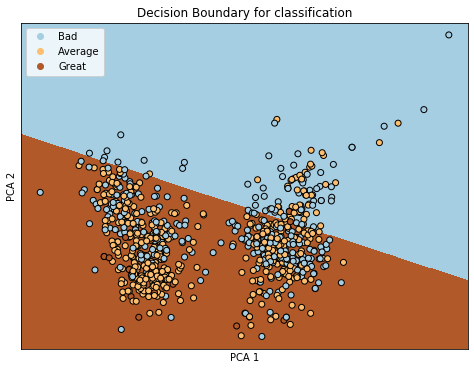

In [98]:
#Code adopted from: https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html

label_text = ["Bad", "Average", "Great"]

dim1 = "PCA 1"
dim2 = "PCA 2"

# Plotting decision regions
X = x_train_2d
Y = y_train
# Create an instance of Logistic Regression Classifier and fit the data.
logregplot = LogisticRegression(C=1000, solver='liblinear')
logregplot.fit(X, Y)


# Plot the decision boundary. 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logregplot.predict(np.stack((xx.ravel(), yy.ravel()), axis=1))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, shading='auto', cmap=plt.get_cmap('Paired',3))


# Plot also the training points
sc = plt.scatter(X[:, 0], X[:, 1],  c = Y, edgecolors='k', cmap=plt.get_cmap('Paired',3))
plt.xlabel(dim1)
plt.ylabel(dim2)
plt.title("Decision Boundary for classification")

# produce a legend from the scatter
plt.legend(handles=sc.legend_elements()[0], labels = label_text)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [96]:
print(np.unique(Z,return_counts=True))
np.unique(Y.values,return_counts=True)

(array([0, 1]), array([220077, 169767]))


(array([0, 1, 2]), array([303, 478,  19]))

For a Multiclass Logistic Regression with more than 2 predictors, the decision boundary may be hard to visualize geometrically, so the first 2 PCA vectors are used to be able to plot it on the screen.  Even though the prediction accuracy may be high, the resulting visualization may not show it.  Why? Baacuse what might seem inseparable could be separable when the data is projected onto the next PCA axes (eg. PCA3 and PCA4 dimensions), but is useful in centrain situations to visualize the decision boundary. 

<div class="exercise"><b>Exercise 2.5:</b> Comment on the decision boundary above for the multiple logistic regressiopn model.  Does it seem to accurately reflect the classification model?  </div>

<div class="exercise"><b>Exercise 2.6:</b> There are clearly 2 classes of wines that are easily separable (though quality is difficult to predict).  What do you suppose those classes may represent?  What could this suggest for possible decisions in feature engineering (hint: think interactions)? </div>



## Part 3: KNN Classificaton

Ref: https://medium.com/analytics-vidhya/knn-k-nearest-neighbors-1add1b5d6eb2

![knn](knn.png) 




The model assigns the data to different categories based on the k nearest neighbours from it. The distance is usually the Eucledean distance in feature space, but could also be based on other metrics like Minkowski distance, Manhattan distance, etc.

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
knn = KNeighborsClassifier(10)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [40]:
print("Classification accuracy for knn10: \n Train =",
    knn.score(x_train,y_train),", Test =", knn.score(x_test,y_test))

Classification accuracy for knn10: 
 Train = 0.69625 , Test = 0.6


<div class="exercise"><b>Exercise 3.1: Find the Classification accuracy by fitting a a few different KNN models with k of oyur choice. How does the accuracy vary? What happens when k = 1?</b> </div>

In [41]:
#Your answer

knn = KNeighborsClassifier(1)
knn.fit(x_train,y_train)
print("Classification accuracy for knn: \n Train =",
    knn.score(x_train,y_train),", Test =", knn.score(x_test,y_test))

Classification accuracy for knn: 
 Train = 1.0 , Test = 0.615


You might see that 1NN has a very high train accuracy. The model assigns a data point to the class of its closest neighbour in the feature space.

<div class="exercise"><b>Exercise 3.2: Plot the variation of classification accuracy with different k, k={1,3,5,7,10,15,25,100}</b> </div>

Text(0.5, 1.0, 'Classification accuracy vs k')

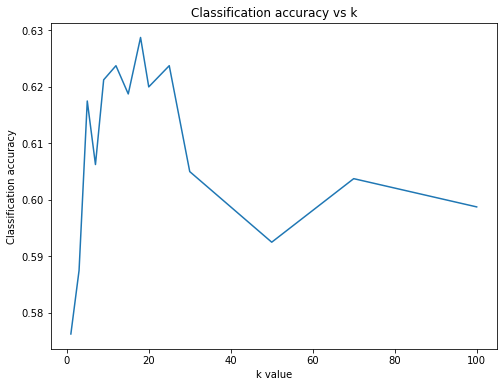

In [42]:
#Your answer
from sklearn.model_selection import cross_val_score #Another neat way to CV

acc = []
k_vals = [1,3,5,7,9,12,15,18,20,25,30,50,70,100]

for k in k_vals:
    knn_model = KNeighborsClassifier(k)
    acc.append(np.mean(cross_val_score(knn_model, x_train, y_train, cv=10))) 
plt.figure(figsize = (8,6))    
plt.plot(k_vals, acc)
plt.xlabel('k value')
plt.ylabel('Classification accuracy')
plt.title("Classification accuracy vs k")

So it seems like k = 20 has the highest accuracy.

<div class="exercise"><b>Exercise 3.3: Plot the classification boundary of the best performing model. Use the PCA1 and PCA2 as the axes</b> </div>

<ipython-input-43-572b6333eb3c>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x1v, x2v, yhat.reshape(x1v.shape))


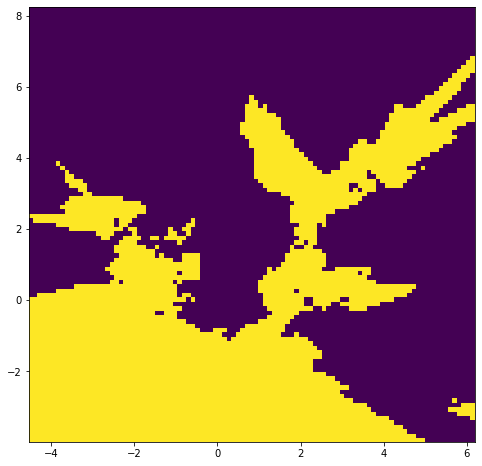

In [43]:
#Your answer

n = 100

x1=np.linspace(np.min(x_train_2d[:,0]),np.max(x_train_2d[:,0]),n)
x2=np.linspace(np.min(x_train_2d[:,1]),np.max(x_train_2d[:,1]),n)
x1v, x2v = np.meshgrid(x1, x2)


knn = KNeighborsClassifier(20)
knn.fit(x_train_2d,y_train)

# To do the predictions and keep the yhats on 2-D (to match the dummy predictor shapes), use this
yhat = knn.predict(np.c_[x1v.ravel(), x2v.ravel()])
plt.figure(figsize = (8,8))
plt.pcolormesh(x1v, x2v, yhat.reshape(x1v.shape)) 
plt.show()

## Part 4: Evaluate Models via Confusion matrices and ROC Curves

Some of the methods of evaluating Classification models are Confusion matrices and ROC curves.

### Confusion Matrix
As a reminder of Confustion Matrices:
- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the standard form, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

In [44]:
# Removing the third class. ROC curves work well with binary classification
x_train_new = x_train[y_train!=2]
y_train_new = y_train[y_train!=2]

x_test_new = x_test[y_test!=2]
y_test_new = y_test[y_test!=2]


In [45]:
from sklearn.metrics import confusion_matrix

knn20 = KNeighborsClassifier(20)
knn20.fit(x_train_new,y_train_new)

y_pred_train = knn20.predict(x_train_new)
y_pred_test = knn20.predict(x_test_new)



In [46]:
logreg = LogisticRegression(C=1000, solver='liblinear')
logreg.fit(x_train_new,y_train_new)

y_log_pred_train = logreg.predict(x_train_new)
y_log_pred_test = logreg.predict(x_test_new)

<div class="exercise"><b>Exercise 4.1: Obtain the confusion matrix for the Classsification models above. Which of the two models do you think performs better? </b> </div>

In [47]:
#Your answer
conf_mat_knn = pd.DataFrame(
    confusion_matrix(y_test_new, y_pred_test), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

conf_mat_knn

,pred:0,pred:1
true:0,31,45
true:1,29,91


In [48]:
#Your answer
conf_mat_log = pd.DataFrame(
    confusion_matrix(y_test_new, y_log_pred_test), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

conf_mat_log

,pred:0,pred:1
true:0,52,24
true:1,24,96


#### Interpreting the Confusion Matrix

The confusion matrix takes a classification model's evluation a bit deeper than simply using overall classification accuracy, but it has its limitations.  The two major ones are:

1. If your classes are severely unbalanced, then your model(s) may predict everyone to be in a single class when using the Bayes' classifier (think: what if 99% of your data are all in class 1?)
2. There still could be a lot of ties when comparing models.  For example, changing the regularization parameter from 0.01 to 0.1 may in the end result in the same rates of false positives and false negatives.

A more holistic approach (improving the two issues mentioned above) to evaluating classificiation models is preferred.

### ROC curve

The ROC curve (receiver operating characteristic curve) improves on the use of a single confusion matrix.  It essentially created a large number of confusion matrices at prespecified values of the decision threshold (not just 0.5), and plots the resulting true positive and false positive rates.  It gives a broader picture to aid in evaluating a single or several different classification models.

Note: it works only for a binary outcome!

In [49]:
#####
#Make ROC curves to evaluate a model's overall useability.
#####

from sklearn.metrics import roc_curve, auc
import seaborn as sns

# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
        
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax


sns.set_context("poster")
    

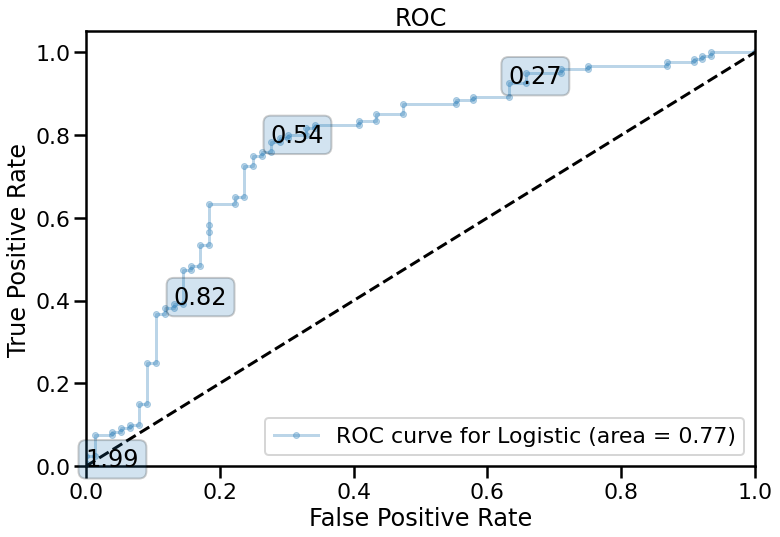

In [50]:
make_roc("Logistic", logreg, y_test_new, x_test_new, ax=None, labe=20, proba=True, skip=1);

<div class="exercise"><b>Exercise 4.2: Obtain a ROC curve for the knn20 model </b> </div>

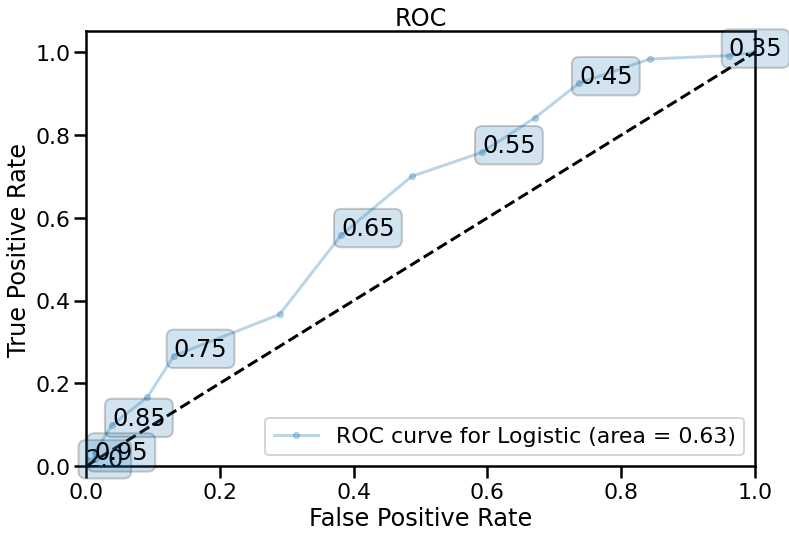

In [51]:
make_roc("Logistic", knn20, y_test_new, x_test_new, ax=None, labe=2, proba=True, skip=1);

#### Interpreting the ROC Curve

<div class="exercise"><b>Exercise 4.3: What do the number superimposed on the ROC curve represent?  Which of the two models compared above is better based on the ROC curves?  Based on the AUC?  Is that model always superior given a False Positive Rate?  What would AUC value of 0.5 mean?  </b> </div>

# Bonus: Using statsmodels to perform inference in logistic regression

Instead of sklearn, we can also use `statsmodels` for classification. It also allows use to perform some inferences while sing the logistic regression. An example is shown below

In [52]:
import statsmodels.api as sm


x_train_const = sm.add_constant(x_train_new)
x_test_const = sm.add_constant(x_test_new)


sm_model = sm.Logit(y_train_new, x_train_const).fit()

print(sm_model.params)

Optimization terminated successfully.
         Current function value: 0.496481
         Iterations 8
const                   100.473417
fixed acidity             0.181259
volatile acidity         -3.918034
citric acid              -0.859633
residual sugar            0.117354
chlorides                -0.300133
free sulfur dioxide       0.006441
total sulfur dioxide     -0.008261
density                -113.242469
pH                        0.713512
sulphates                 1.505628
alcohol                   0.988973
red                      -0.130102
dtype: float64


In [53]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                quality   No. Observations:                  781
Model:                          Logit   Df Residuals:                      768
Method:                           MLE   Df Model:                           12
Date:                Fri, 16 Jul 2021   Pseudo R-squ.:                  0.2566
Time:                        03:28:11   Log-Likelihood:                -387.75
converged:                       True   LL-Null:                       -521.57
Covariance Type:            nonrobust   LLR p-value:                 2.829e-50
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  100.4734    133.432      0.753      0.451    -161.048     361.995
fixed acidity            0.1813      0.145      1.246      0.213      -0.104       0.466
volatile acidity        -3.9180      0.806     -4.859      0.000      -5.498      -2.338
citric acid             -0.8596      0.723     -1.189      0.234      -2.277       0.557
residual sugar           0.1174      0.056      2.083      0.037       0.007       0.228
chlorides               -0.3001      2.415     -0.124      0.901      -5.033       4.433
free sulfur dioxide      0.0064      0.008      0.793      0.428      -0.009       0.022
total sulfur dioxide    -0.0083      0.003     -2.480      0.013      -0.015      -0.002
density               -113.2425    135.868     -0.833      0.405    -379.540     153.055
pH                       0.7135      0.915      0.780      0.436      -1.080       2.507
sulphates                1.5056      0.689      2.186      0.029       0.156       2.855
alcohol                  0.9890      0.177      5.587      0.000       0.642       1.336
red                     -0.1301      0.528     -0.246      0.805      -1.166       0.905
========================================================================================
"""

<div class="exercise"><b>Exercise 4.4: Interpret the output above.  Which variable is most strongly related to the response in the cointext of this model?  Interpret the results for the variable $\texttt{density}$.  </b> </div>

In [54]:
y_sm_pred_train = sm_model.predict(x_train_const)>.5
y_sm_pred_test = sm_model.predict(x_test_const)>.5

#calculate the accuracy
print(f"Train Accuracy: {(y_train_new==y_sm_pred_train).mean()} \nTest Accuracy: {(y_test_new==y_sm_pred_test).mean()}")

Train Accuracy: 0.7516005121638925 
Test Accuracy: 0.7602040816326531
